# Deep Learning
# DL12 PM2.5 Serie Tiempo 1D Convolucion

## <font color='blue'>**1D-CNN aplicado a series de tiempo univariadas.**</font>
<p style='text-align: justify;'>

Una serie de tiempo es una serie de puntos de datos indexados (o listados o graficados) en orden de tiempo. Más comúnmente, una serie de tiempo es una secuencia tomada en sucesivos puntos equidistantes en el tiempo. Por lo tanto, es una secuencia de datos de tiempo discreto. Ejemplos de series temporales son las alturas de las mareas oceánicas, los recuentos de manchas solares y el valor de cierre diario del Promedio Industrial Dow Jones.

Las series temporales se trazan con mucha frecuencia a través de gráficos de líneas. Las series de tiempo se usan en estadística, procesamiento de señales, reconocimiento de patrones, econometría, finanzas matemáticas, pronóstico del tiempo, predicción de terremotos, electroencefalografía, ingeniería de control, astronomía, ingeniería de comunicaciones y en gran medida en cualquier dominio de la ciencia aplicada y la ingeniería que involucra mediciones temporales.

El término "serie temporal univariadas" se refiere a una serie temporal que consiste en observaciones individuales (escalares) registradas secuencialmente en incrementos de tiempo iguales
    
En este notebook, utilizaremos una red convolucional de una dimensión para desarrollar modelos de pronóstico de series temporales univariadas.
El conjunto de datos utilizado para los ejemplos de este notebook es sobre la contaminación del aire medida por la concentración de material particulado (PM) de diámetro menor o igual a 2.5 micrómetros. Hay otras variables
tales como presión de aire, temperatura del aire, punto de rocío, que tambien serán utilizadas para realizar presiccones.
</p>

En este caso, se desarrollará un modelo de series temporales: para la predicción de pm2.5.
El notebook se divide en la siguiente etapas:
1. Visualización de la data
2. Procesamiento de la data
3. Construcción del modelo y su entrenamiento
4. Resultados y validación del modelo.


Importancia de la predicción del material particulado:

<p style='text-align: justify;'>
El material particulado respirable presente en la atmósfera de nuestras ciudades en forma sólida o líquida (polvo, cenizas, hollín, partículas metálicas, cemento y polen, entre otras) se puede dividir, según su tamaño, en dos grupos principales. A las de diámetro aerodinámico igual o inferior a los 10 µm o 10 micrómetros (1 µm corresponde a la milésima parte de un milímetro) se las denomina PM10 y a la fracción respirable más pequeña, PM2,5. Estas últimas están constituidas por aquellas partículas de diámetro aerodinámico inferior o igual a los 2,5 micrómetros, es decir, son 100 veces más delgadas que un cabello humano
</p>

El conjunto de datos se ha descargado del Repositorio de aprendizaje automático de UCI.
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

### Etapa 1: Visualización de la data

<p style='text-align: justify;'>
En esta etapa nos hacemos una idea de como es la distribución de la data. Entre que valores fluctua,  en el caso de las series de tiempo univariadas, es natural realizar Boxplots y graficos de tiempo. Las librerías tipicas que utilizaremos en esta etapa son: pandas, matplotlib, numpy y seaborn.
</p>

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [ ]:
#Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Leamos el dataset a pandas.DataFrame
#Read the dataset into a pandas.DataFrame
file_path ="/content/drive/MyDrive/TalentoDigital_MK_II/Trabajo_CD/6.Deep_learning/Data/PRSA_data_2010.1.1-2014.12.31.csv"
df = pd.read_csv(file_path)

In [ ]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (43824, 13)


In [ ]:
# Miremos los 5 primeros registros.
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


#### Datos faltantes:

En los datos de series de tiempo, si faltan valores, hay dos formas de tratar los datos incompletos:

1. omita todo el registro que contiene información.
2. Imputar la información que falta.

Dado que los datos de series temporales tienen propiedades temporales, solo algunas de las metodologías estadísticas son apropiadas para los datos de series temporales.

Métodos elementales de imputación:
1. Usando la media
2. Usando la mediana
3. Usando la moda
4. Calcular una medición apropiada y reemplazar los NAs.
5. Utilizar modelos estadísticos y de Machine Leaning.

In [ ]:
"""
Las filas que tienen valores de NaN en la columna pm2.5 se descartan. Debemos considerar en
el caso que los NaN son demasiados o nos afecten en nuestras predicciones, existen metodos para ir rellenando los valores.
La opción mas directa es eliminarlos. Veamos si esto nos afecta en nuestro modelo.
"""
df.dropna(subset=['pm2.5'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

<p style='text-align: justify;'>
En las series de tiempo el orden es fundamental.
Para asegurarse de que las filas estén en el orden correcto de fecha y hora de las observaciones, se crea una nueva columna fecha y hora a partir de las columnas relacionadas con la fecha y la hora del Marco de datos.
La nueva columna consta de los objetos DateTime.datetime de Python. El DataFrame se ordena en orden ascendente sobre esta columna.
    </p>

In [ ]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

Un `box plot` es una forma estandarizada de mostrar la distribución de datos basada en un resumen de cinco números
("mínimo", primer cuartil (Q1), mediana, tercer cuartil (Q3) y "máximo"). Puede informarle sobre sus valores atípicos y cuáles son sus valores. También puede decirle si sus datos son simétricos, qué tan estrechamente están agrupados, y si sus datos están sesgados.

Necesita tener información sobre la variabilidad o dispersión de los datos. Un 'box plot' es un gráfico que le da una buena indicación de cómo se distribuyen los valores en los datos. Aunque los 'box plots' pueden parecer primitivos en comparación con un histograma o gráfico de densidad, tienen la ventaja de ocupar menos espacio, lo cual es útil al comparar distribuciones entre muchos grupos o conjuntos de datos.


<img alt="box plot"  src="https://drive.google.com/uc?export=view&id=1nYNJiDz5NpdSMKuXVkVWYA4H-pROctQo" width=600px>


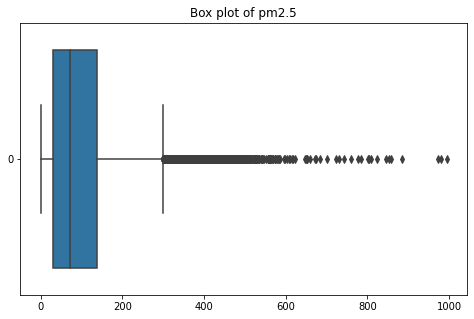

In [ ]:
# Dibujemos un box plot para visualizar la tendencia central y dispersión de PRES
plt.figure(figsize=(8, 5))
g = sns.boxplot(data=df['pm2.5'], orient='h')
g.set_title('Box plot of pm2.5')
plt.show()

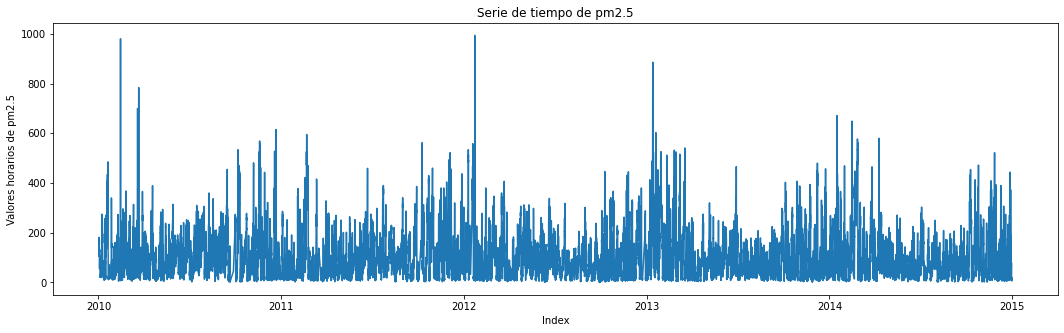

In [ ]:
plt.figure(figsize=(18, 5))
g = sns.lineplot(x=df['datetime'], y=df['pm2.5'])
g.set_title('Serie de tiempo de pm2.5')
g.set_xlabel('Index')
g.set_ylabel('Valores horarios de pm2.5')
#plt.savefig('B07887_05_10.png', format='png', dpi=300)
plt.show()

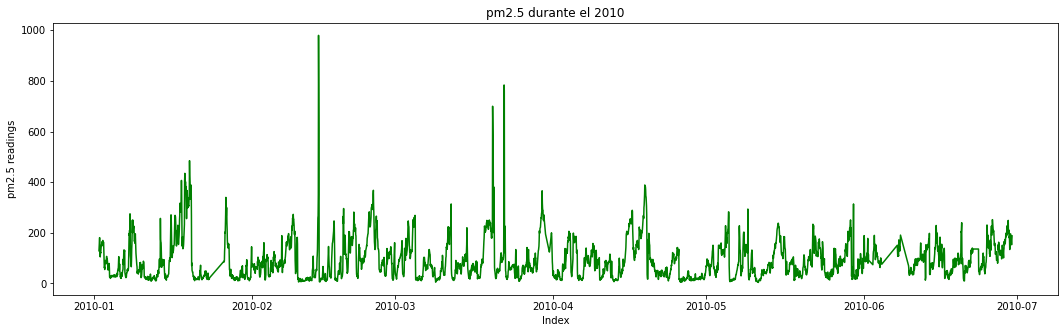

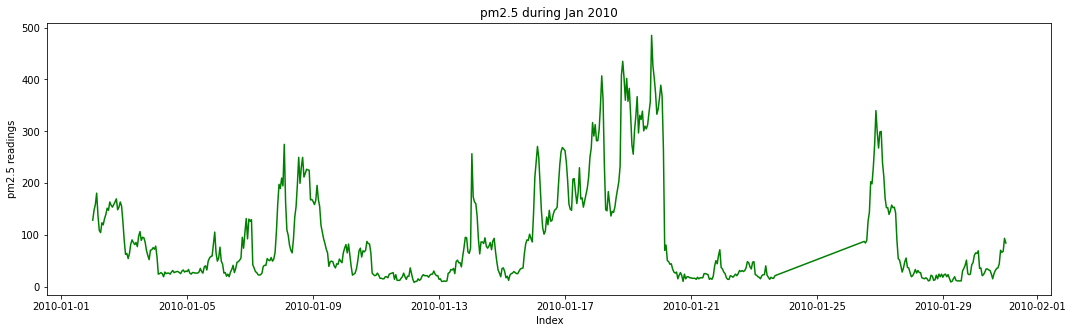

In [ ]:
# Grafiquemos una serie de tiempo de 6 meses y veamos patrones.
plt.figure(figsize=(18, 5))
g = sns.lineplot(x=df['datetime'], y=df['pm2.5'].loc[df['datetime']<=datetime.datetime(year=2010,month=6,day=30)], color='g')
g.set_title('pm2.5 durante el 2010')
g.set_xlabel('Index')
g.set_ylabel('pm2.5 readings')
# plt.savefig('B07887_05_07.png', format='png', dpi=300)
plt.show()

#Let's zoom in on one month.
plt.figure(figsize=(18, 5))
g = sns.lineplot(x=df['datetime'], y=df['pm2.5'].loc[df['datetime']<=datetime.datetime(year=2010,month=1,day=31)], color='g')
g.set_title('pm2.5 during Jan 2010')
g.set_xlabel('Index')
g.set_ylabel('pm2.5 readings')
# plt.savefig('B07887_05_08.png', format='png', dpi=300)
plt.show()

### Etapa 2 Preprocesamiento de la data
<p style='text-align: justify;'>
En esta segunda etapa preparamos los datos con el objetivo de realizar un entrenamiento robusto de nuestra red neuronal. Usualmente los datos como primera etapa se normalizan. Empiricamente se ha observando que los datos normalizados (No siempre) generan modelos de clasificiación y de regresión con mejores metricas que los no nromalizadas. Por otra parte, Los algoritmos de descenso de gradiente funcionan mejor (por ejemplo, convergen más rápido) si las variables están dentro del rango [-1, 1]. Muchas fuentes relajan el límite incluso [-3, 3].</p>
<p style='text-align: justify;'>
Posteriormente los datos debens ser separados en tres conjuntos: Entrenamiento, validación y test. Usualmente el ultimo de test se utiliza con una prueba nueva de datos. Finalmente debemos construir el conjunto de vectores que serán utilizados para entrenar la red neuronal perceptron multicapa. Las librerias. Adicionalmente en esta sección utilizaremos la librería sklearn para realizar la normalización.
</p>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_pm2.5'] = scaler.fit_transform(np.array(df['pm2.5']).reshape(-1, 1))

<p style='text-align: justify;'>
Antes de entrenar el modelo, el conjunto de datos se divide en dos partes: conjunto de entrenamiento y conjunto de validación.
La red neuronal se entrena en el conjunto de entrenamiento. Esto significa el cálculo de la función de pérdida, backpropagation
y los pesos actualizados por un algoritmo de descenso de gradiente se realizan en el conjunto de entrenamiento. El conjunto de validación se utiliza para evaluar el modelo y para determinar el número de epochs en el entrenamiento del modelo. Aumentando el número de epochs disminuirán aún más la función de pérdida en el conjunto de entrenamiento, pero es posible que no necesariamente tengan el mismo efecto para el conjunto de validación debido al sobreajuste en el conjunto de entrenamiento. Utilizamos Keras con el backend Tensorflow para definir y entrenar el modelo. Todos los pasos involucrados en la capacitación y validación del modelo se realizan llamando a las funciones apropiadas de la API de Keras.
 </p>

In [ ]:
"""
Comencemos dividiendo el conjunto de datos en entrenamiento y validación. El período de tiempo del conjunto de datos si es de
1 de enero de 2010 al 31 de diciembre de 2014. Los primeros cuatro años: 2010 a 2013 se utiliza como entrenamiento y
2014 se mantiene para validación.
"""
# Utilizamos pandas para realizar este proceso.
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (33096, 15)
Shape of test: (8661, 15)


In [ ]:
#Miremos nuestro conjunto de entrenamiento
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_pm2.5
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00,0.129779
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00,0.148893
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00,0.159960
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00,0.182093
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00,0.138833


In [ ]:
#Miremos nuestro conjunto de validación
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_pm2.5
33096,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.024145
33097,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.053320
33098,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.065392
33099,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.070423
33100,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.079477


In [ ]:
#Vamos a resetar los indices para ser ordenados
df_val.reset_index(drop=True, inplace=True)

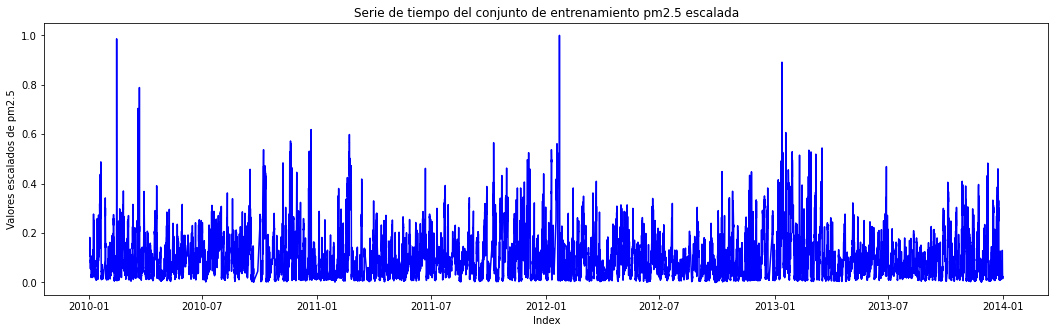

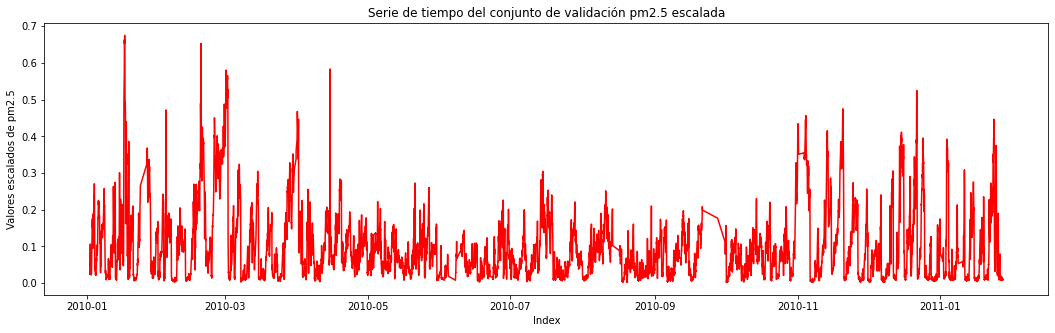

In [ ]:
"""
El conjunto de entrenamiento y validación lo volvemos a dibujar.
"""

plt.figure(figsize=(18, 5))
g = sns.lineplot(x=df['datetime'], y=df_train['scaled_pm2.5'], color='b')
g.set_title('Serie de tiempo del conjunto de entrenamiento pm2.5 escalada')
g.set_xlabel('Index')
g.set_ylabel('Valores escalados de pm2.5')
plt.show()

plt.figure(figsize=(18, 5))
g = sns.lineplot(x=df['datetime'], y=df_val['scaled_pm2.5'], color='r')
g.set_title('Serie de tiempo del conjunto de validación pm2.5 escalada')
g.set_xlabel('Index')
g.set_ylabel('Valores escalados de pm2.5')
plt.show()

<p style='text-align: justify;'>
Ahora necesitamos generar vectores (X) y una variable objetivo (y) para entrenar y validar. La matriz de los regresores o variables independientes y la matriz  de la variable dependiente se crean a partir de la matriz 1-D original de la columna scaled_pm2.5. Para el modelo de pronóstico de series de tiempo, los últimos siete días de observaciones se utilizan para predecir el día siguiente, este valor se estudia y se pueden ejercitar distintas ventanas de tiempo. el dia 7 surge de la observación de los gráficos de linea.  Definimos una función que toma la serie de tiempo original y el número de pasos de tiempo en los regresores como entrada para generar las matrices de X e y. </p>

In [ ]:
def makeXy(ts, nb_timesteps):
    """
    Input:
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output:
           X: 2-D array of regressors
           y: 1-D array of target
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [ ]:
X_train, y_train = makeXy(df_train['scaled_pm2.5'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (33089, 7) (33089,)


In [ ]:
X_val, y_val = makeXy(df_val['scaled_pm2.5'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8654, 7) (8654,)


### Definiendo el modelo de 1D-CNN
<p style='text-align: justify;'>
    
Comprendamos cómo funciona la convolución 1D. Considere la siguiente figura que muestra una serie de tiempo de diez pasos de tiempo. Un filtro (1 x -1) + (2x1) + (-1 x 2) = -1 se mueve un paso de una unidad de tiempo sobre la serie. Por lo tanto, se genera un mapa de características 1 x 8. El primer elemento de la
el mapa de características se calcula como se mostró anteriormente. El resto de los pasos de tiempo se calculan de manera similar. No hemos rellenado con ceros la serie de tiempo original (Padding), por lo que el mapa de características es dos unidades más corto que la serie original. Sin embargo, rellenar con cero el inicio y el final de la serie de tiempo de entrada y usar el mismo filtro habría resultado en un mapa de características 1 x 10. Adicionalmente Una capa de agrupación se puede apilar con la capa convolucional para reducir la muestra del mapa de características.</p>



![1D-convolucional](https://drive.google.com/uc?export=view&id=1s2Uc3QfrW6Cxf5GB391VvHqnCBmbuT2L)


<p style='text-align: justify;'>
El enfoque de usar un filtro de convolución 1 x 3 es equivalente a entrenar varios modelos locales autorregresivos de orden tres. Estos modelos locales generan características sobre subconjuntos a corto plazo de las series de tiempo de entrada. Cuando se usa una capa de agrupación promedio después de 1D capa de convolución, crea promedios móviles sobre el mapa de entidades generado por la capa de convolución anterior. Además, varias capas de convolución y agrupación 1D, cuando se apilan entre sí, brindan una forma poderosa de extraer características de la serie de tiempo original. Por lo tanto, el uso de CNNs resulta ser efectivo cuando se trata de series de tiempo complejas y no lineales, como ondas de audio, habla, etc. De hecho, las CNN se han aplicado con éxito en la clasificación de ondas de audio. </p>



### Un ejemplo con Keras


![Acelerometro](https://drive.google.com/uc?export=view&id=1fHzzgEwQgZfHwixQX4OUuu79sSik-fdj)


En este ejemplo, nos enfocaremos en los datos del sensor de acelerómetro de tiempo reducido que provienen de un teléfono inteligente que llevan sus usuarios en la cintura. Según los datos del acelerómetro de los ejes x, y y z, la CND 1D debe predecir el tipo de actividad que realiza un usuario (como "Caminar", "Trotar" o "Pararse").



![1D-convolucional](https://drive.google.com/uc?export=view&id=1B9qtmqNTDUBNzHe5nz0eawKt9AnJcX-G)




```python
model_m = Sequential() # Aqui vamos a apilar capas.
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
```

__Datos de entrada__: los datos se han preprocesado de tal manera que cada registro de datos contiene 80 segmentos de tiempo. Dentro de cada intervalo de tiempo, se almacenan los tres valores para el eje x, el eje y y el eje z. Esto da como resultado una matriz de 80 x 3. La linea `Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))` tiene por objetivo transformar de un vector de 240 a un tensor 80x3.


__Primera capa 1D-CNN__: La primera capa define un filtro (o también llamado detector de características) para este caso de altura 10 (también llamado tamaño kernel). Solo definir un filtro permitiría a la red neuronal aprender una sola característica en la primera capa. Esto podría no ser suficiente, por lo tanto, definiremos 100 filtros. Esto nos permite entrenar 100 características diferentes en la primera capa de la red. La salida de la primera capa de red neuronal es una matriz de 71 x 100 neuronas. Cada columna de la matriz de salida contiene los valores obtenidos de aplicar un solo filtro. Con el tamaño del kernel definido y considerando la longitud de la matriz de entrada, cada filtro generará 71 valores.


__Segunda capa 1D-CNN__: El resultado de la primera CNN se introducirá en la segunda capa de CNN. Nuevamente definiremos 100 filtros diferentes para ser entrenados en este nivel. Siguiendo la misma lógica que la primera capa, la matriz de salida tendrá un tamaño de 62 x 100.

__Capa max pooling__: A menudo se usa una capa de agrupación después de una capa CNN para reducir la complejidad de la salida y evitar el sobreajuste de los datos. En nuestro ejemplo elegimos un tamaño de tres. Esto significa que el tamaño de la matriz de salida de esta capa es solo un tercio de la matriz de entrada.

__3ra y  4ta capas 1D-CNN__: Sigue otra secuencia de capas 1D CNN para aprender características de nivel superior. La matriz de salida después de esas dos capas es una matriz de 2x160.

__Capa average polling__: Una capa de agrupación más para evitar aún más el sobreajuste. Esta vez no se toma el valor máximo, sino el valor promedio de dos pesos dentro de la red neuronal. La matriz de salida tiene un tamaño de 1x160 neuronas. Por detector de características solo queda un peso en la red neuronal en esta capa.

__Capa dropout__: La capa de abandono asignará aleatoriamente 0 pesos a las neuronas en la red. Como elegimos una tasa de 0.5, el 50% de las neuronas recibirán un peso cero. Con esta operación, la red se vuelve menos sensible para reaccionar a variaciones más pequeñas en los datos. Por lo tanto, debería aumentar aún más nuestra precisión en datos no vistos. La salida de esta capa sigue siendo una matriz de neuronas 1 x 160.

__Capa fully connected__: La capa final reducirá el vector de altura 160 a un vector de seis, ya que tenemos seis clases que queremos predecir ("trotar", "sentado", "caminar", "de pie", "arriba", "abajo") . Esta reducción se realiza mediante otra multiplicación de matriz. Softmax se utiliza como la función de activación. Obliga a las seis salidas de la red neuronal a sumar una. Por lo tanto, el valor de salida representará la probabilidad para cada una de las seis clases.

### El ejemplo de pm2.5
El tensor de entrada a las capas de convolución debe tener forma (número de muestras, número de pasos de tiempo, número de características por paso de tiempo). En este caso, estamos modelando solo pm2.5, por lo tanto, el número de características por paso de tiempo es uno. El número de pasos de tiempo es siete y el número de muestras es igual al número de muestras en X_train y X_val, que se reforman en matrices 3D.

In [ ]:
#X_train and X_val are reshaped to 3D arrays
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),\
                 X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Forma de la matriz después del reshaping:', X_train.shape, X_val.shape)

Forma de la matriz despues del reshaping: (33089, 7, 1) (8654, 7, 1)


Ahora vamos a definir una topologia con capas 1D-CNN para el data set pm2.5.

In [ ]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import ZeroPadding1D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from tensorflow.keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
# Defina la capa de entrada que recibe tensores (x,7,1).
input_layer = Input(shape=(7,1), dtype='float32')

La capa ZeroPadding1D se agrega a continuación para agregar ceros al principio y al final de cada serie. El relleno cero asegura que la capa de convolución aguas abajo no reduzca la dimensión de las secuencias de salida. Capa de agrupación, agregada después de que la capa de convolución se usa para reducir el muestreo de la entrada.

In [ ]:
# Agregamos cero padding
zeropadding_layer = ZeroPadding1D(padding=1)(input_layer)

El primer argumento de Conv1D es la cantidad de filtros, que determinan la cantidad de características en la salida. El segundo argumento indica la longitud de la ventana (kernel) de convolución 1D. El tercer argumento son los pasos y representan el número de lugares para cambiar la ventana de convolución. Por último, estableciendo use_bias como True, agregue un valor de sesgo durante el cálculo de una función de salida. Aquí, se puede pensar que la convolución 1D genera modelos AR locales sobre una ventana móvil de tres unidades de tiempo.

In [ ]:
# Añadimos una capa 1D convolution.
# Se crean 64 máscaras de tamaño 3. Se inicializan de forma aleatoria y cambian con el
# entrenamiento
conv1D_layer1 = Conv1D(64, 3, strides=1, use_bias=True)(zeropadding_layer)
conv1D_layer2 = Conv1D(32, 3, strides=1, use_bias=True)(conv1D_layer1)

Se agrega AveragePooling1D al lado de reducir la entrada al tomar el promedio sobre el tamaño de la agrupación de tres con pasos de un paso de tiempo. La agrupación promedio en este caso puede considerarse como tomar promedios móviles sobre una ventana móvil de tres unidades de tiempo. Hemos utilizado la agrupación promedio en lugar de la agrupación máxima para generar los promedios móviles.

In [ ]:
# Agregamos capa AveragePooling1D.
avgpooling_layer = AveragePooling1D(pool_size=3, strides=1)(conv1D_layer2)

La capa de agrupación anterior devuelve la salida 3D. Por lo tanto, antes de pasar a la capa de salida, se agrega una capa Flatten. La capa Flatten cambia la forma de la entrada a (número de muestras, número de pasos de tiempo * número de características por paso de tiempo), que luego se alimenta a la capa de salida

In [ ]:
#Agregamos capa  Flatten.
flatten_layer = Flatten()(avgpooling_layer)

In [ ]:
# Una capa densa.
dense_layer1 = Dense(32)(flatten_layer)
# Una de dropout
dropout_layer = Dropout(0.2)(dense_layer1)
# Otra capa densa.
dense_layer2 = Dense(16)(dropout_layer)
# Otra de dropout
dropout_layer = Dropout(0.2)(dense_layer2)

In [ ]:
# Finalmente, la capa de salida da predicciones para la presión de aire del día siguiente.
output_layer = Dense(1, activation='linear')(dropout_layer)

Las capas de entrada, densa y de salida ahora se empaquetarán dentro de un Modelo, que es una clase de envoltura para entrenamiento y creación. El diagrama de caja de pm2.5 muestra la presencia de valores atípicos. Por lo tanto, usaremos el __error absoluto medio (MAE)__  como métrica, ya que las desviaciones absolutas sufren menos fluctuaciones en comparación con las desviaciones al cuadrado.

Los pesos de la red están optimizados por el algoritmo Adam. Adam representa la estimación del momento adaptativo y ha sido una opción popular para entrenar redes neuronales profundas. A diferencia del descenso de gradiente estocástico, Adam usa diferentes tasas de aprendizaje para cada peso y se actualizan por separado. Conforme el entrenamiento progresa, la tasa de aprendizaje de un peso se actualiza con base en promedios móviles ponderados exponencialmente de los gradientes del peso y los gradientes al cuadrado.

In [ ]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
ts_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 zero_padding1d (ZeroPadding  (None, 9, 1)             0         
 1D)                                                             
                                                                 
 conv1d (Conv1D)             (None, 7, 64)             256       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 32)             6176      
                                                                 
 average_pooling1d (AverageP  (None, 3, 32)            0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 96)                0     

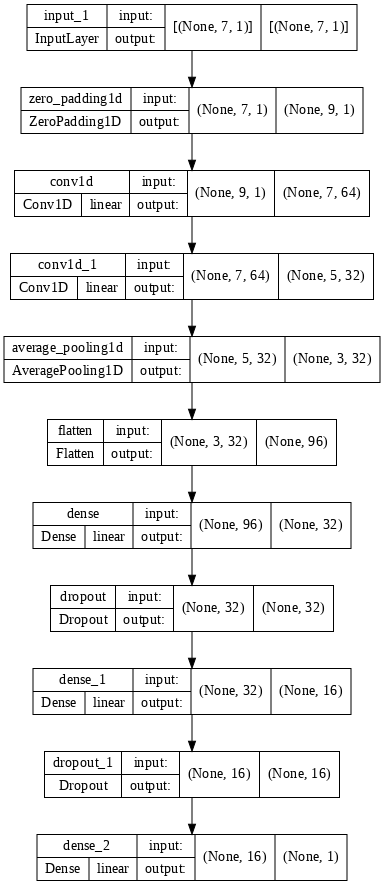

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(ts_model,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True,
           dpi=72,
           layer_range=None,
           show_layer_activations=True
           )

El modelo se entrena llamando a la función de ajuste en el objeto modelo y pasando el X_train y el y_train. El entrenamiento
se realiza para un número predefinido de epochs. Además, batch_size define el número de muestras del conjunto de entrenamiento para ser utilizado para una instancia de backpropagation. El conjunto de datos de validación también se pasa para evaluar el modelo después de cada epoch es completado. Un objeto ModelCheckpoint rastrea la función de pérdida en el conjunto de validación y guarda el modelo para la epoch, en el cual la función de pérdida ha sido mínima.

In [ ]:
path = '/content/drive/My Drive/Cursos/Diplomado/Kafka/PrediccionPm2.5-MLP/models'
path = "/content/drive/MyDrive/TalentoDigital_MK_II/Trabajo_CD/6.Deep_learning/Data/"
save_weights_at = os.path.join(path+'/keras_models', 'PRSA_data_PM2.5_1DConv_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at,
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True,
                            save_weights_only=False,
                            mode='min',
                            save_freq='epoch')

ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 6s 3ms/step - loss: 0.0181 - val_loss: 0.0186
Epoch 2/20
2069/2069 [==============================] - 11s 5ms/step - loss: 0.0181 - val_loss: 0.0130
Epoch 3/20
2069/2069 [==============================] - 6s 3ms/step - loss: 0.0180 - val_loss: 0.0162
Epoch 4/20
2069/2069 [==============================] - 6s 3ms/step - loss: 0.0178 - val_loss: 0.0131
Epoch 5/20
2069/2069 [==============================] - 6s 3ms/step - loss: 0.0179 - val_loss: 0.0137
Epoch 6/20
2069/2069 [==============================] - 6s 3ms/step - loss: 0.0179 - val_loss: 0.0133
Epoch 7/20
2069/2069 [==============================] - 8s 4ms/step - loss: 0.0179 - val_loss: 0.0131
Epoch 8/20
2069/2069 [==============================] - 6s 3ms/step - loss: 0.0179 - val_loss: 0.0156
Epoch 9/20
2069/2069 [==============================] - 7s 3ms/step - loss: 0.0178 - val_loss: 0.0141
Epoch 10/20
2069/2069 [==============================] - 6s 3ms/step - loss: 0.01

## <font color='green'>**Actividad 1**</font>

Proponga, construya y entrene su propia red neuronal. (40 Minutos)

<font color='green'>Fin Actividad 1</font>

## <font color='green'>**Actividad 2**</font>

Evalue el resultado del modelo (30 minutos). Utilice
1. MAE
2. $R^2$
3. Gráfico de línea.

<font color='green'>Fin Actividad 2</font>

<img src="https://drive.google.com/uc?export=view&id=1Igtn9UXg6NGeRWsqh4hefQUjV0hmzlBv" width="100" align="left" title="Runa-perth">
<br clear="left">

## <font color='red'>**Series de tiempos multivariadas y CNN.**</font>

**Clasificador de Series Temporales Multivariadas con Redes Convolucionales**

Las redes convolucionales no están reservadas exclusivamente para la clasificación de imágenes. De hecho, pueden ser una herramienta eficaz para el análisis de series temporales, especialmente cuando se trata de series temporales multivariadas donde diferentes variables evolucionan con el tiempo.

En este ejercicio, se le desafía a construir un clasificador para una serie temporal multivariada utilizando redes convolucionales:

1. Genere una serie temporal multivariada ficticia. Por simplicidad, esta serie temporal puede tener dos clases: clase A y clase B. (Puede usar funciones senoidales, cosenoidales y añadir ruido para diferenciar entre las dos clases).

2. Divida el conjunto de datos en entrenamiento y prueba.

3. Diseñe una red neuronal convolucional que pueda recibir la serie temporal multivariada y clasificarla en una de las dos clases.

4. Entrene el modelo y evalúe su precisión en el conjunto de prueba.

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten
from sklearn.model_selection import train_test_split

# 1. Generación de serie temporal multivariada ficticia
np.random.seed(42)
timesteps = 100
data_size = 1000

# Funciones senoidales y cosenoidales con ruido
class_A = np.array([np.sin(np.linspace(0, 10, timesteps)) + np.random.normal(0, 0.2, timesteps) for _ in range(data_size)])
class_B = np.array([np.sin(np.linspace(0, 10, timesteps)) + np.random.normal(0, 0.5, timesteps) for _ in range(data_size)])

X = np.vstack([class_A, class_B])
y = np.array([0] * data_size + [1] * data_size)

# 2. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# 3. Diseño de la red neuronal convolucional
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(timesteps, 1)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 4. Entrenar y evaluar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {score[1]*100:.2f}%")


Epoch 1/10
50/50 [==============================] - 3s 26ms/step - loss: 0.3542 - accuracy: 0.8794 - val_loss: 0.0824 - val_accuracy: 1.0000
Epoch 2/10
50/50 [==============================] - 1s 18ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 3/10
50/50 [==============================] - 1s 17ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 1s 19ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 1s 16ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 1s 11ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 1s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 8/10
50

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split

# 1. Generación de serie temporal multivariada ficticia
np.random.seed(42)
timesteps = 100
data_size = 1000
num_features = 2  # número de variables en la serie temporal

# Crear series de tiempo multivariadas para ambas clases
class_A = np.array([np.column_stack([np.sin(np.linspace(0, 10, timesteps)) + np.random.normal(0, 0.2, timesteps),
                                     np.cos(np.linspace(0, 10, timesteps)) + np.random.normal(0, 0.2, timesteps)])
                    for _ in range(data_size)])

class_B = np.array([np.column_stack([np.sin(np.linspace(0, 10, timesteps)) + np.random.normal(0, 0.5, timesteps),
                                     np.cos(np.linspace(0, 10, timesteps)) + np.random.normal(0, 0.5, timesteps)])
                    for _ in range(data_size)])

X = np.vstack([class_A, class_B])
y = np.array([0] * data_size + [1] * data_size)

# 2. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Diseño de la red neuronal convolucional
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(timesteps, num_features)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 4. Entrenar y evaluar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {score[1]*100:.2f}%")


Epoch 1/10
50/50 [==============================] - 2s 14ms/step - loss: 0.3414 - accuracy: 0.8838 - val_loss: 0.0673 - val_accuracy: 1.0000
Epoch 2/10
50/50 [==============================] - 1s 11ms/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 3/10
50/50 [==============================] - 1s 13ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 1s 19ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 1s 10ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 8/10
50